In [3]:
import sys
sys.path.append('../../')

In [4]:
from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter

from numpy.polynomial.polynomial import polyfit, polyval

In [5]:
def DFA_main(DATA):
    # output:
    # F_n: RMS(Root Mean Squared) values in each window length
    # Alpha1: the Hurst exponent
    N = len(DATA)  # length of the data
    win_lengths = np.arange(20, len(DATA)/2, 20).astype(int) # how many different win_lengths, customized to your data
    Nw = len(win_lengths) # number of different win_length
    F_n = np.zeros(Nw) # initialize RMS values in the FDA time series
    order=1 # (default to 1 in DFA_main function);

    for iw in range(Nw):
        win_length=win_lengths[iw]
        n = int(np.floor(N / win_length))  # the number of windows
        N1 = n * win_length  # new length of the truncated data 
        # initialize y
        y = np.zeros(N1)  # sum of deviations from the grand mean in all data length
        # initialize fitcoef
        mean1 = np.mean(DATA[:N1]) # grand mean of the truncated data
        # sum of deviations from the grand mean in all data length
        #for i in range(N1):
        #    y[i] = np.sum(DATA[:i+1] - mean1)
        y = np.cumsum(DATA[:N1]-mean1)

        # polynomial coefficients in each window
        fitcoef = np.zeros((n, order + 1))
        for j in range(n):
            fitcoef[j,:] = np.polyfit(np.arange(1, win_length+1), y[j*win_length:(j+1)*win_length], order)
        # initialize Yn (the new Y values in each window)
        Yn = np.zeros(N1)
        for j in range(n): # the number of windows
            Yn[j*win_length:(j+1)*win_length] = np.polyval(fitcoef[j,:], np.arange(1, win_length+1))

        sum1 = np.sum((y.T - Yn)**2) / N1 # take the mean square
        sum1 = np.sqrt(sum1) # take the root
    
        F_n[iw] = sum1 # the final RMS (root mean squared value)

    A = np.polyfit(np.log10(win_lengths), np.log10(F_n), 1)
    Alpha1 = A[0]
    # FitValues = np.polyval(A, np.log10(win_lengths))
    return Alpha1
    # return win_lengths, F_n, Alpha1, FitValues
    

In [6]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes   


In [7]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

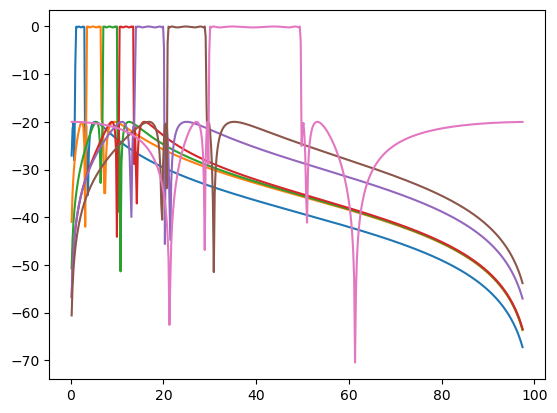

In [8]:
# build the narrow band filters
srnew = 200 
downsample = 10 
passbands = [[1,3],[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29],[30,49.5]]
stopbands = [[0.75,3.25],[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5],[29.5,50]]
bandlabels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    plt.plot(w[1:500],20*np.log10(np.abs(h[1:500])))


In [9]:
# organize file in time sequence
filedir="../../"
pathname = 'Cleaned_data/'
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)

In [10]:
# hilbert_data288=dict(); n=0
# for ses in range(12):
# 	filename='clean_'+str(filedates[ses])+'.mat'
# 	# load one session data
# 	[eeg, intervals, samples, condition_index, session, sr, bpchan, 
# 			condition_Names, channels, chan_labels, sessionTypes] \
# 				= loaddata(filedir+pathname+filename)
# 	# construct lowpass filter for downsampling
# 	sos_low, w,h = makefiltersos(sr,50,55)
# 	for trl in range(12): # for each trial
# 		#align the length of the two files. 
# 		nsamp1 = np.shape(eeg[0][trl])[0]
# 		nsamp2 = np.shape(eeg[1][trl])[0]
# 		nsamp = np.min((nsamp1,nsamp2))
# 		for subj in range(2): # for each subject
# 			# average referencing
# 			trialdata = avref(eeg[subj][trl][0:nsamp,0:32]) 
# 			# lowpass filtering
# 			trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
# 			# downsampling
# 			trialdatanew = trialdata[range(0,nsamp,downsample),:]
# 			filtdata = dict()
# 			# time = dict()
# 			hilbertdata = dict()
# 			empirical_ampcorr = dict()
# 			phasecorr = dict() #need to to do this still. 
# 			for freq in range(len(passbands)):
# 				filtdata[freq] = sosfiltfilt(esos[freq],trialdatanew,axis = 0,padtype ='odd')
# 				hilbertdata[freq] = hilbert(filtdata[freq],axis = 0)
# 				empirical_ampcorr[freq] = np.corrcoef(np.transpose(np.abs(hilbertdata[freq])))
# 			# put all variables needed in a dictionary for each trial (288 trials)
# 			trial_dict=dict()
# 			trial_dict['session']=session-1 # 0 for synch, 1 for synco
# 			trial_dict['sessionTypes']=sessionTypes[session-1] # string value "synch" or "synco"
# 			trial_dict['ses']=ses # session number in time sequence from 0 to 11
# 			trial_dict['subj']=subj # 0 for L subject, 1 for R subject
# 			trial_dict['trl']=trl # trial number in time sequence
# 			trial_dict['condition_index']=condition_index[trl] # condition index 0 to 3
# 			trial_dict['hilbertdata']=hilbertdata
# 			trial_dict['empirical_ampcorr']=empirical_ampcorr
# 			hilbert_data288[n]=trial_dict
# 			n+=1


# # takes 46s for one ses in HP laptop
# # takes 40s for one ses in hnlb 
# # total estimate 40x12 = 8 min

In [12]:
for ses in range(1,12):
	filename='clean_'+str(filedates[ses])+'.mat'
	[eeg, intervals, samples, condition_index, session, sr, bpchan, 
				condition_Names, channels, chan_labels, sessionTypes] \
					= loaddata(filedir+pathname+filename)

	#make a low pass filter @ 50 Hz 
	sos_low, w,h = makefiltersos(sr,50,55)
	Hurst = np.zeros((12,2,7,32))
	for trial in range(12):
		nsamp1 = np.shape(eeg[0][trial])[0]
		nsamp2 = np.shape(eeg[1][trial])[0]
		nsamp = np.min((nsamp1,nsamp2))
		for subject in range(2): 
			trialdata = avref(eeg[subject][trial][0:nsamp,0:32]) 
			trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
			trialdatanew = trialdata[range(0,nsamp,downsample),:]
			for frequency in range(7):
				filtdata = sosfiltfilt(esos[frequency],trialdatanew,axis = 0,padtype ='odd')
				hilbertdata = hilbert(filtdata,axis = 0)
				for channel in range(32):
					Hurst[trial,subject,frequency,channel]=DFA_main(np.abs(hilbertdata[:,channel]))
	outdict = dict()
	outdict['eeg_Hurst'] = Hurst
	outdict['new_sr'] = srnew
	outdict['passbands'] = passbands
	outdict['stopbands'] = stopbands
	outdict['band_labels'] = bandlabels
	outdict['filename'] = filename
	outdict['condition_index'] = condition_index
	outdict['condition_names'] = condition_Names
	outdict['channels'] = channels
	outdict['channel_labels'] = chan_labels
	outdict['intervals'] = intervals
	outdict['samples'] = samples
	outdict['sessionTypes'] = sessionTypes
	outdict['session'] = session*np.ones(12)
	savemat('Hurst_eeg_20_'+str(filedates[ses]),outdict,store_python_metadata = True) 

# done in 142 min
